Tutorial from https://morris-lab.github.io/CellOracle.documentation/notebooks/04_Network_analysis/Network_analysis_with_Paul_etal_2015_data.html

# 0. Import libraries

In [1]:
# Import libraries

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

In [2]:
import celloracle as co
co.__version__

/home/xqf2zp/.local/lib/python3.11/site-packages/loompy/bus_file.py:67: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/xqf2zp/.local/lib/python3.11/site-packages/loompy/bus_file.py:84: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/xqf2zp/.local/lib/python3.11/site-packages/loompy/bus_file.py:101: NumbaDeprecationWarning: The 'nopython' keywo

'0.17.1'

In [3]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [4]:
save_folder = "fetal_celloracle_grn_figures"
os.makedirs(save_folder, exist_ok=True)

# 1. Load data

In [5]:
adata = sc.read_h5ad('preprocessed_human_6_8_12and19_merged_final_cleaned.h5ad')
adata

AnnData object with n_obs × n_vars = 3748 × 3000
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'Sample', 'read_depth', 'new_manual_annotation', 'time', 'EXPT'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'raw'

In [6]:
print(f"Cell number is: {adata.shape[0]}")
print(f"Gene number is: {adata.shape[1]}")

Cell number is: 3748
Gene number is: 3000


## Build base GRN from scATACseq

In [8]:
# Load TF info.
base_GRN = pd.read_parquet('base_GRN_dataframe.parquet')

# Check data
base_GRN.head()

,peak_id,gene_short_name,9430076C15RIK,AC002126.6,AC012531.1,AC226150.2,AFP,AHR,AHRR,AIRE,...,ZNF784,ZNF8,ZNF816,ZNF85,ZSCAN10,ZSCAN16,ZSCAN22,ZSCAN26,ZSCAN31,ZSCAN4
0,chr10_100009726_100010226,DNMBP,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,chr10_100185874_100186374,ERLIN1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,chr10_100229330_100229830,CHUK,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,chr10_100267454_100267954,CWF19L1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,chr10_100286177_100286677,BLOC1S2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 2. Make Oracle object

In [9]:
# Instantiate Oracle object
oracle = co.Oracle()

In [10]:
# Check data in anndata
print("Metadata columns:", list(adata.obs.columns))
print("Dimensional reduction: ", list(adata.obsm.keys()))

Metadata columns: ['nCount_RNA', 'nFeature_RNA', 'percent.mt', 'Sample', 'read_depth', 'new_manual_annotation', 'time', 'EXPT']
Dimensional reduction:  ['X_harmony', 'X_pca', 'X_umap']


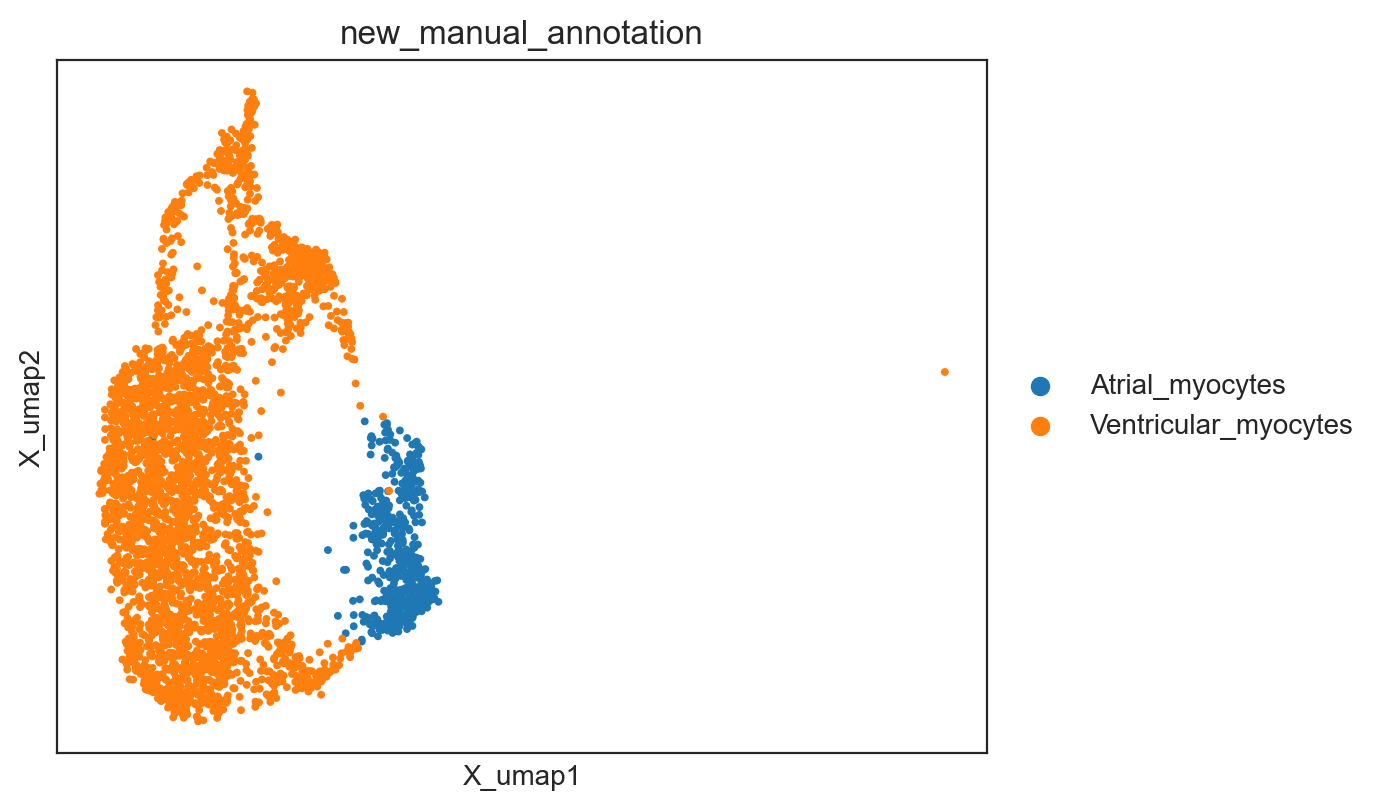

In [11]:
# Instantiate Oracle object.
oracle.import_anndata_as_raw_count(adata=adata, cluster_column_name="new_manual_annotation", embedding_name="X_umap")

In [12]:
# You can load TF info dataframe with the following code.
oracle.import_TF_data(TF_info_matrix=base_GRN)

# Alternatively, if you saved the informmation as a dictionary, you can use the code below.
# oracle.import_TF_data(TFdict=TFinfo_dictionary)

# 3. KNN imputation

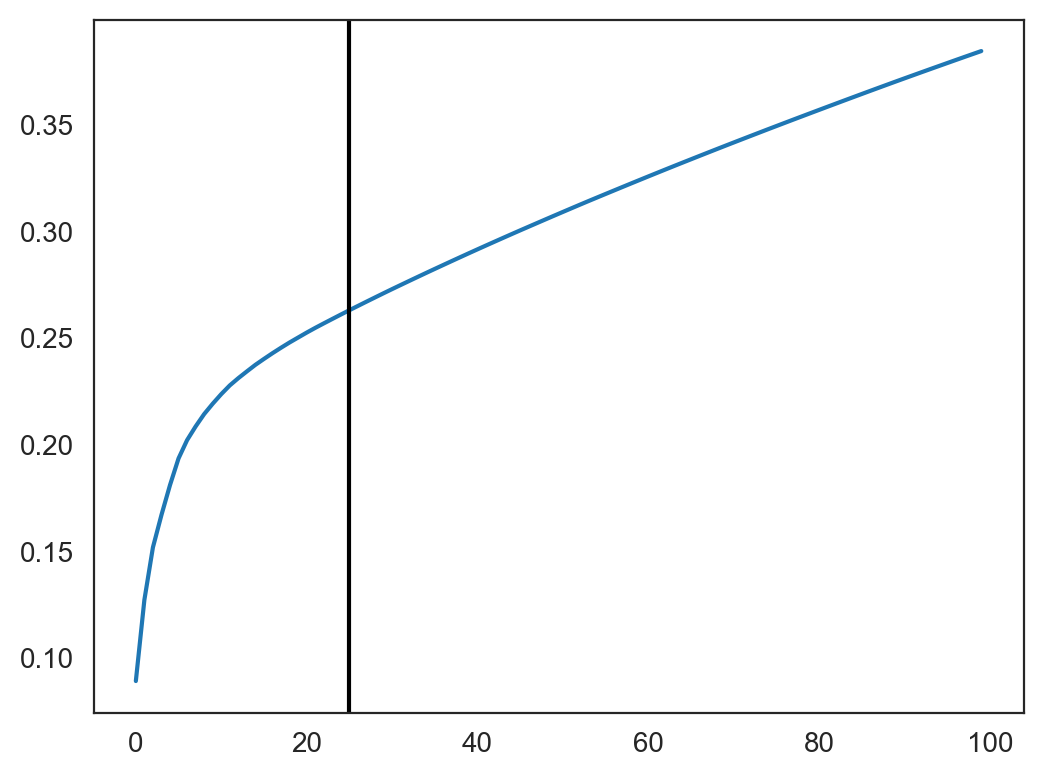

25


In [13]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

In [14]:
n_cell = oracle.adata.shape[0]
print(f"cell number is: {n_cell}")

cell number is: 3748


In [15]:
k = int(0.025*n_cell)
print(f"Auto-selected k is: {k}")

Auto-selected k is: 93


In [16]:
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

# 4. Save and load

In [17]:
# Save oracle object.
oracle.to_hdf5("human_fetal.celloracle.oracle")

# For human fetal data, save Oracle object using Oracle.to_hdf5(FILE_NAME.celloracle.oracle)

In [18]:
# Load file.
oracle = co.load_hdf5("human_fetal.celloracle.oracle")

# 5. GRN calculation

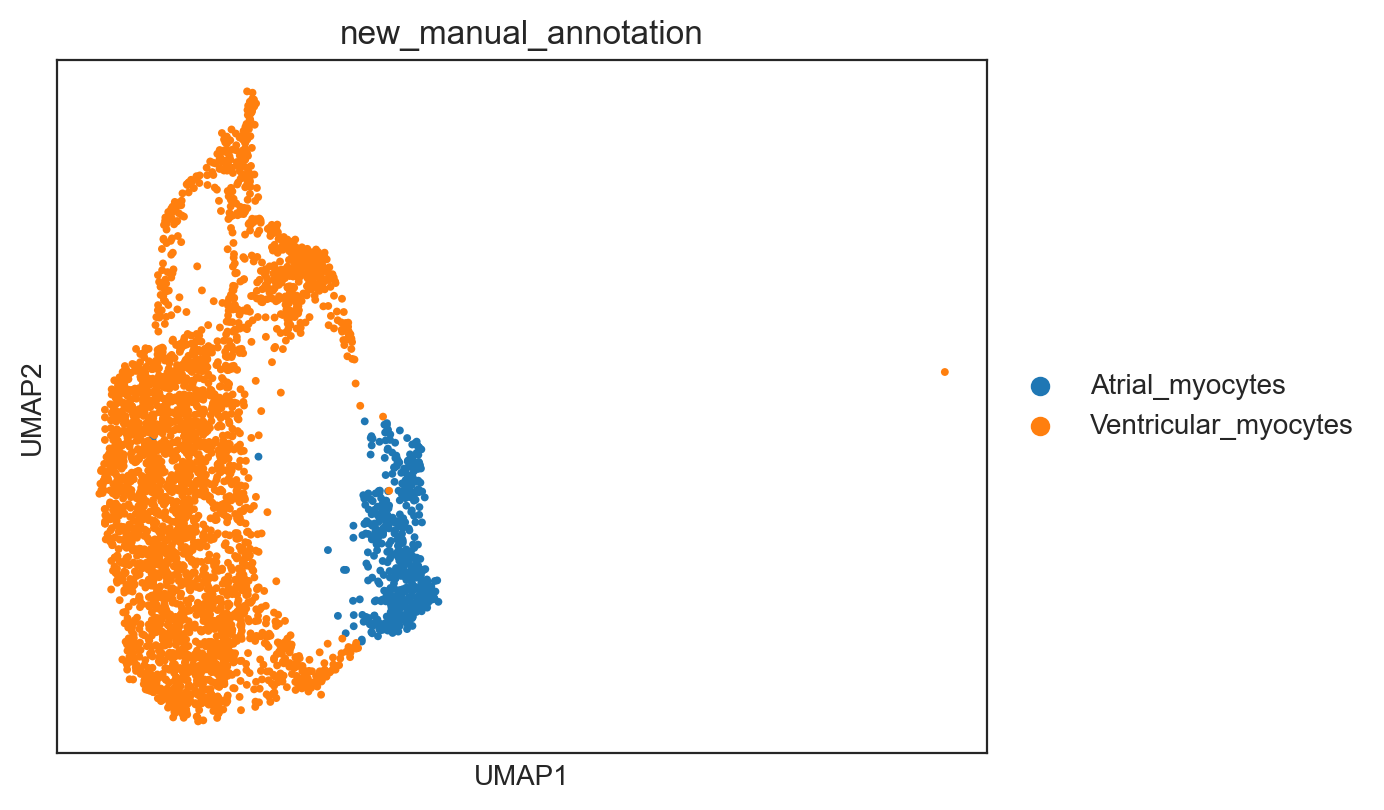

In [19]:
# Check clustering data
sc.pl.umap(oracle.adata, color="new_manual_annotation")

In [20]:
# Calculate GRN for each population in "new_manual_annotation" clustering unit.
links = oracle.get_links(cluster_name_for_GRN_unit="new_manual_annotation", alpha=10, verbose_level=10)

  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Atrial_myocytes...


  0%|          | 0/2141 [00:00<?, ?it/s]

Inferring GRN for Ventricular_myocytes...


  0%|          | 0/2141 [00:00<?, ?it/s]

### Get the GRN for the atrial CM and ventricular CM clusters

In [21]:
links.links_dict.keys()

dict_keys(['Atrial_myocytes', 'Ventricular_myocytes'])

In [22]:
links.links_dict["Atrial_myocytes"]

,source,target,coef_mean,coef_abs,p,-logp
0,SPI1,A2M,0.012105,0.012105,3.525891e-03,2.452731
1,FLI1,A2M,0.011153,0.011153,2.649927e-05,4.576766
2,NR4A2,A2M,0.004012,0.004012,1.359199e-01,0.866717
3,NR4A1,A2M,0.065947,0.065947,2.936641e-18,17.532149
4,ZNF467,A2M,-0.003659,0.003659,4.754939e-05,4.322855
...,...,...,...,...,...,...
43575,ZNF449,ZWINT,-0.002770,0.002770,1.452617e-03,2.837849
43576,TCF4,ZWINT,0.010249,0.010249,3.130711e-05,4.504357
43577,HEY1,ZWINT,-0.003993,0.003993,7.943381e-05,4.099995
43578,YBX1,ZWINT,0.021988,0.021988,6.080280e-07,6.216076


In [23]:
links.links_dict["Ventricular_myocytes"]

,source,target,coef_mean,coef_abs,p,-logp
0,SPI1,A2M,0.018451,0.018451,3.086380e-05,4.510551
1,FLI1,A2M,-0.007885,0.007885,9.433348e-12,11.025334
2,NR4A2,A2M,0.000436,0.000436,8.549237e-01,0.068073
3,NR4A1,A2M,0.054575,0.054575,1.929317e-20,19.714596
4,ZNF467,A2M,-0.013283,0.013283,4.283951e-08,7.368156
...,...,...,...,...,...,...
43575,ZNF449,ZWINT,0.004973,0.004973,6.858827e-04,3.163750
43576,TCF4,ZWINT,-0.044636,0.044636,7.238913e-12,11.140327
43577,HEY1,ZWINT,0.010687,0.010687,4.412333e-04,3.355332
43578,YBX1,ZWINT,0.020365,0.020365,1.275820e-06,5.894211


# 6. Network preprocessing

In [24]:
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)

In [25]:
plt.rcParams["figure.figsize"] = [9, 4.5]

Atrial_myocytes


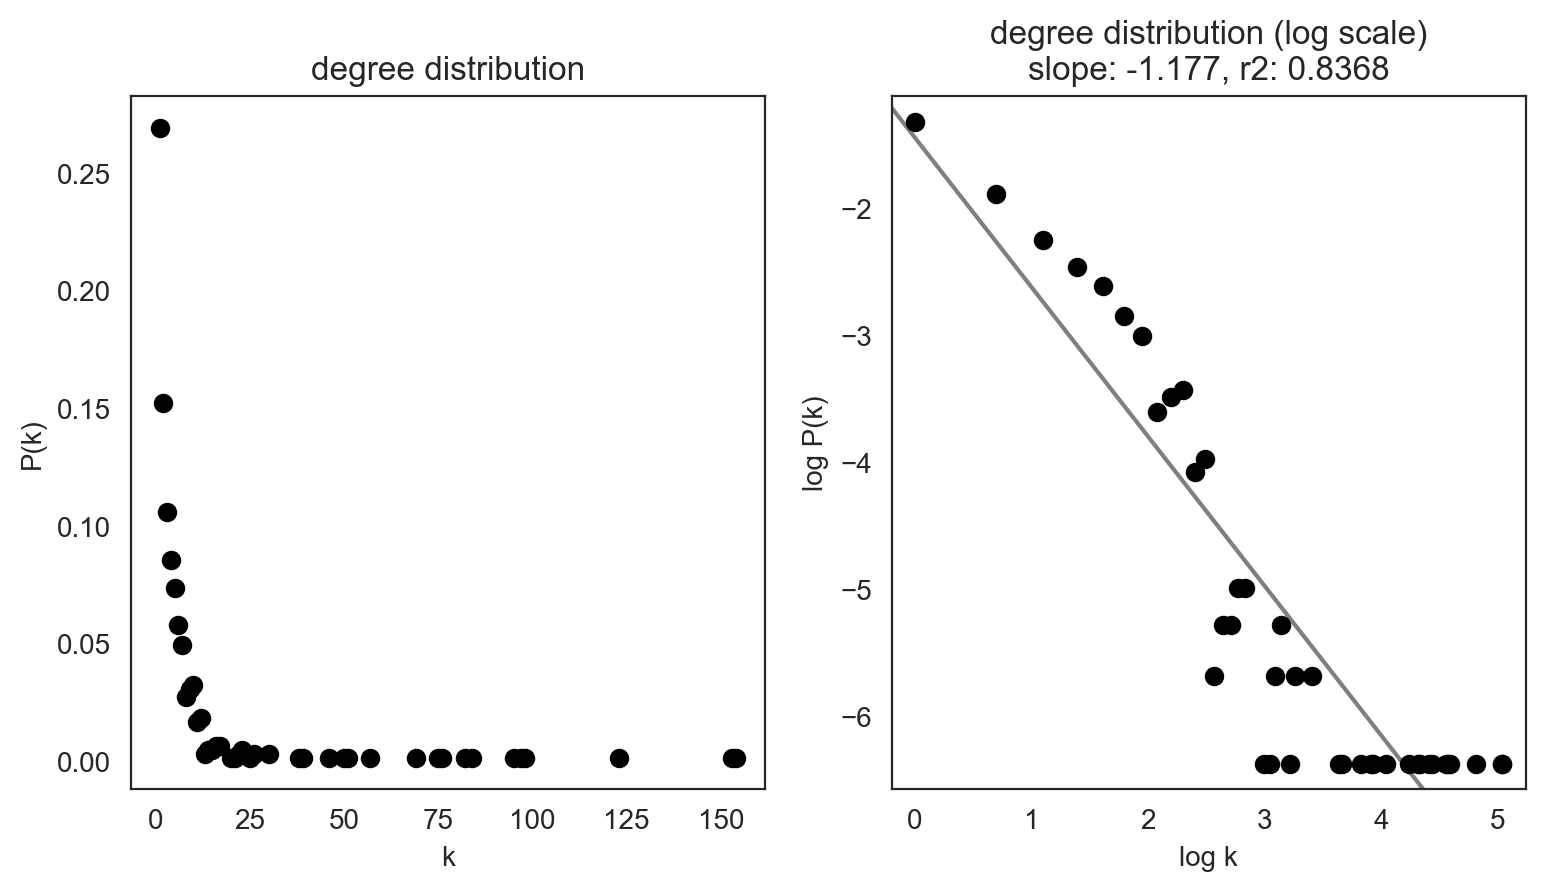

Ventricular_myocytes


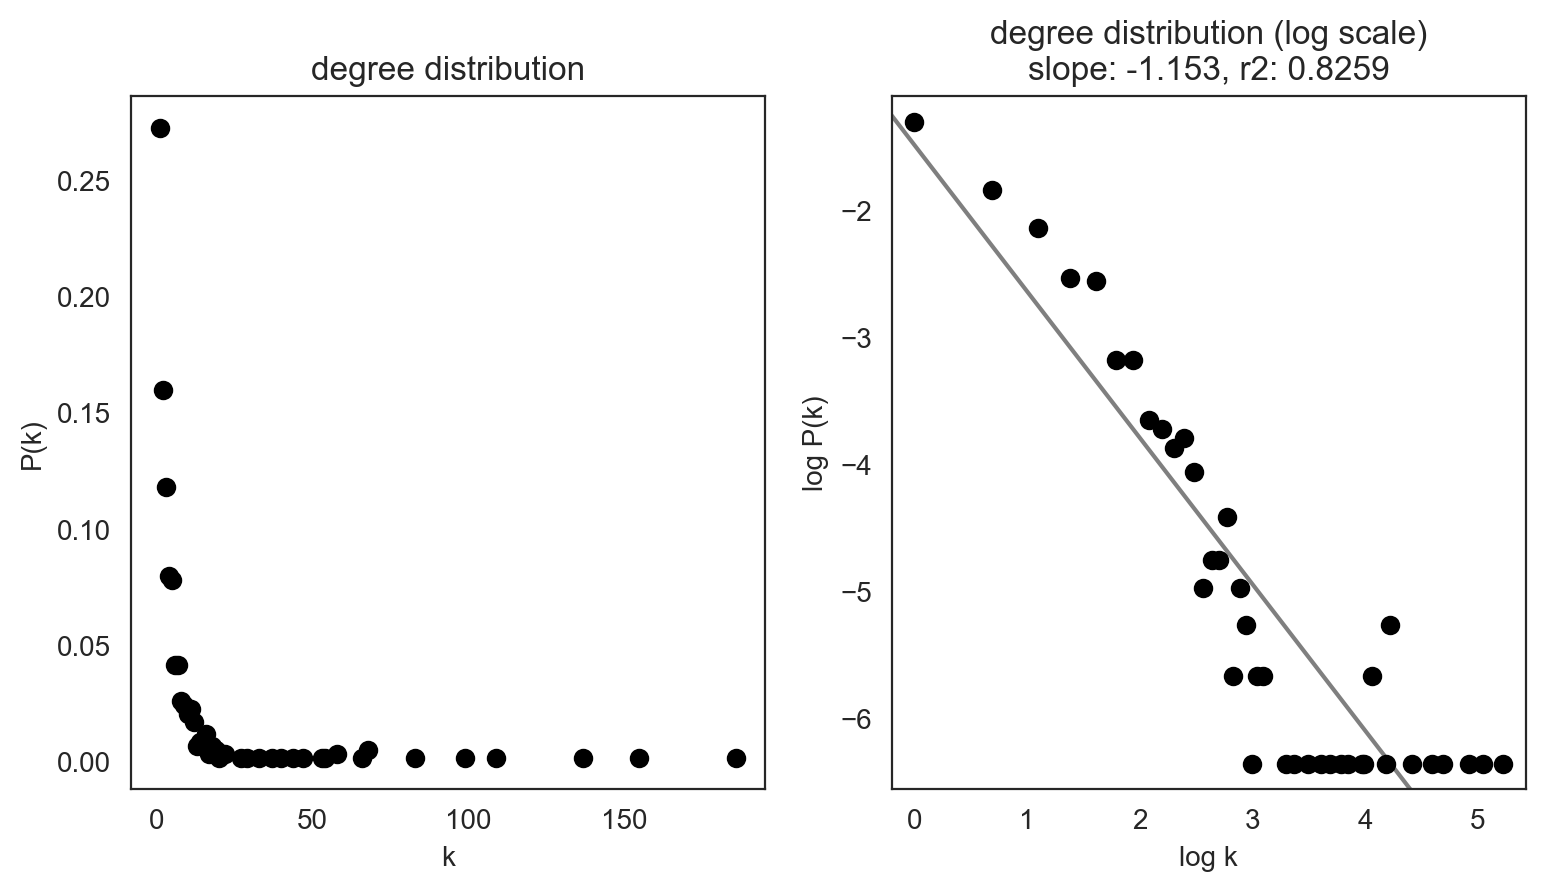

In [26]:
links.plot_degree_distributions(plot_model=True)

In [27]:
plt.rcParams["figure.figsize"] = [6, 4.5]

In [28]:
# Calculate network scores.
links.get_network_score()

In [29]:
links.merged_score.head()

,degree_all,degree_centrality_all,degree_in,degree_centrality_in,degree_out,degree_centrality_out,betweenness_centrality,eigenvector_centrality,cluster
JUNB,51,0.087629,3,0.005155,48,0.082474,733.0,0.564492,Atrial_myocytes
TMSB4X,7,0.012027,7,0.012027,0,0.000000,0.0,0.282180,Atrial_myocytes
JUN,59,0.101375,6,0.010309,53,0.091065,542.0,0.544967,Atrial_myocytes
EGR1,154,0.264605,5,0.008591,149,0.256014,1143.0,1.000000,Atrial_myocytes
FOS,97,0.166667,3,0.005155,94,0.161512,402.0,0.711739,Atrial_myocytes


In [45]:
# Save Links object.
links.to_hdf5(file_path="links.celloracle.links")

In [46]:
# You can load files with the following command.
links = co.load_hdf5(file_path="links.celloracle.links")

# 7. Network analysis; Network score for each gene

In [47]:
# Check cluster name
links.cluster

['Atrial_myocytes', 'Ventricular_myocytes']

In [48]:
links.filtered_links

{'Atrial_myocytes':       source    target  coef_mean  coef_abs             p      -logp
 39213   JUNB    TMSB4X   0.364673  0.364673  2.733276e-16  15.563317
 39216    JUN    TMSB4X  -0.309733  0.309733  1.043333e-13  12.981577
 13885   EGR1       FOS   0.298320  0.298320  6.715542e-23  22.172919
 1208     JUN     ALDOA  -0.292439  0.292439  3.278450e-10   9.484331
 2636    ATF3   ATP5F1B   0.283943  0.283943  1.684626e-09   8.773496
 ...      ...       ...        ...       ...           ...        ...
 37564   E2F3    TCEAL9  -0.036206  0.036206  1.589277e-06   5.798801
 30643   E2F3  RAD51AP1   0.036197  0.036197  5.513074e-08   7.258606
 12005   EGR2      ELOC   0.036171  0.036171  1.583503e-10   9.800381
 28766   KLF2   PLEKHA7  -0.036151  0.036151  1.340129e-05   4.872853
 32823   IRF1    SCAPER   0.036076  0.036076  6.674452e-10   9.175584
 
 [2000 rows x 6 columns],
 'Ventricular_myocytes':        source  target  coef_mean  coef_abs             p      -logp
 24168   NR2F1    MY

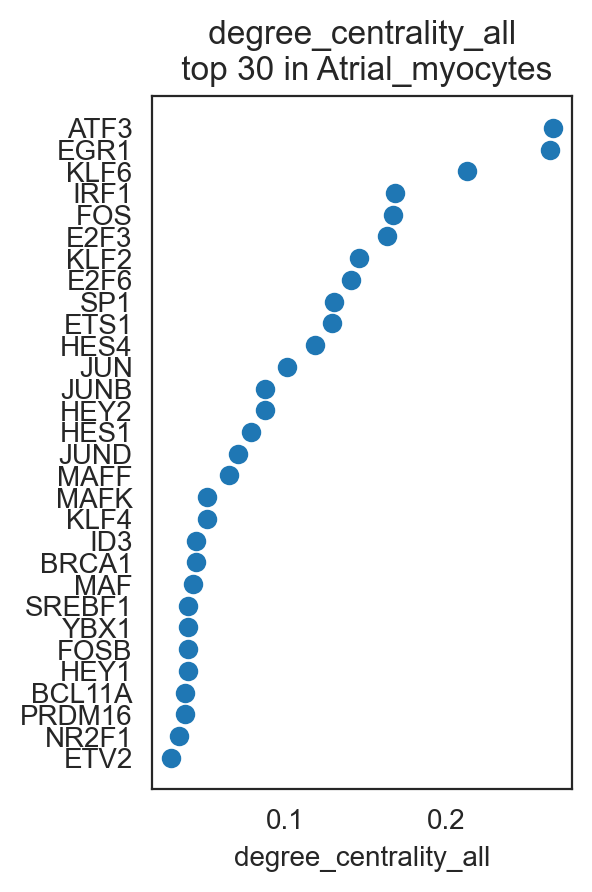

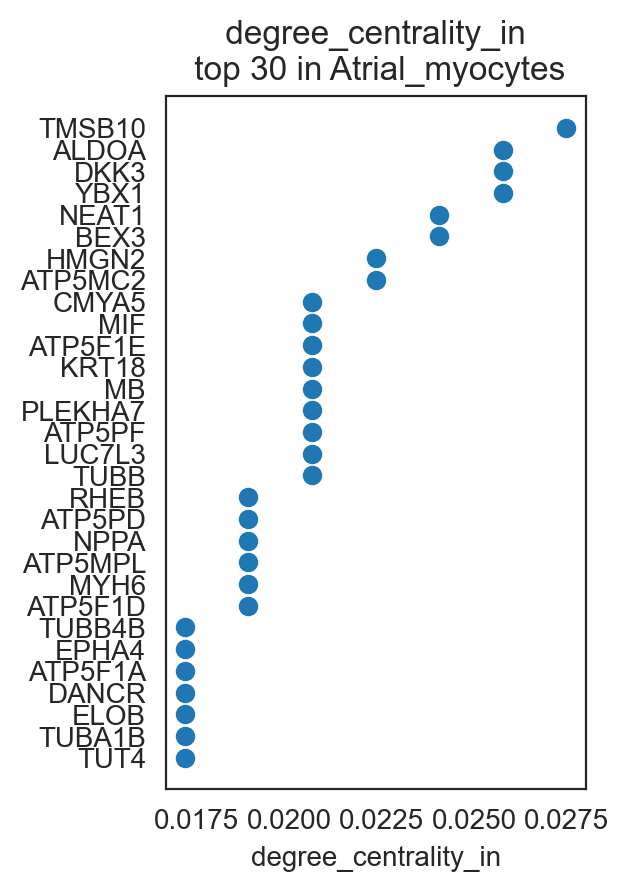

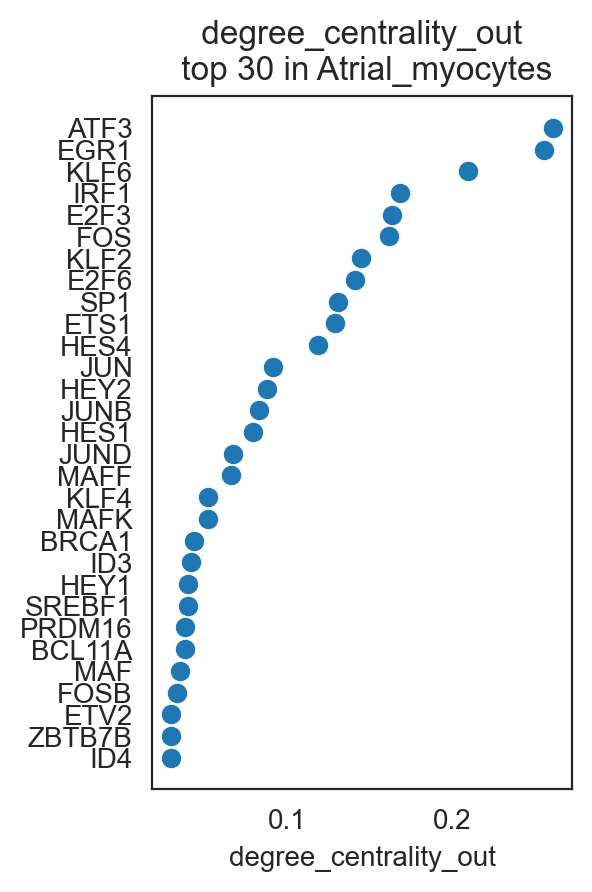

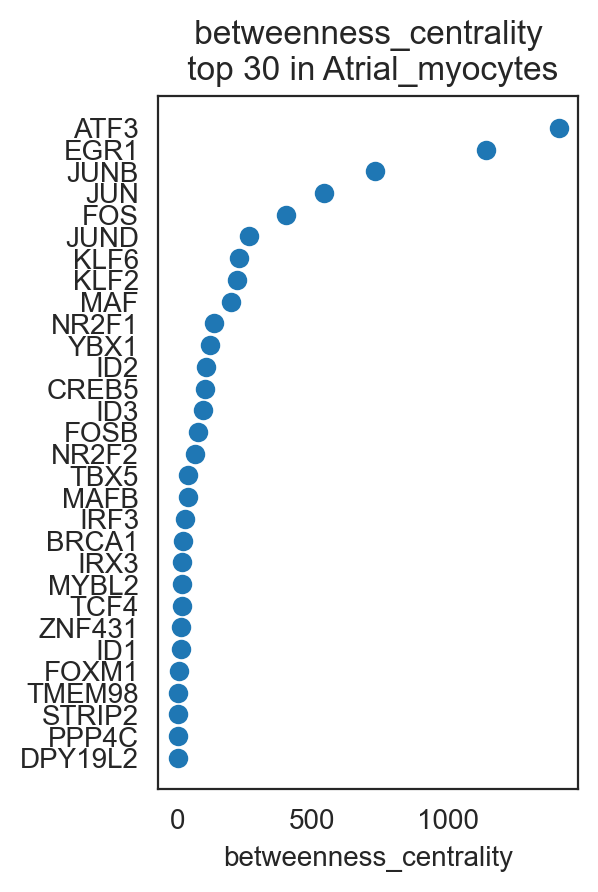

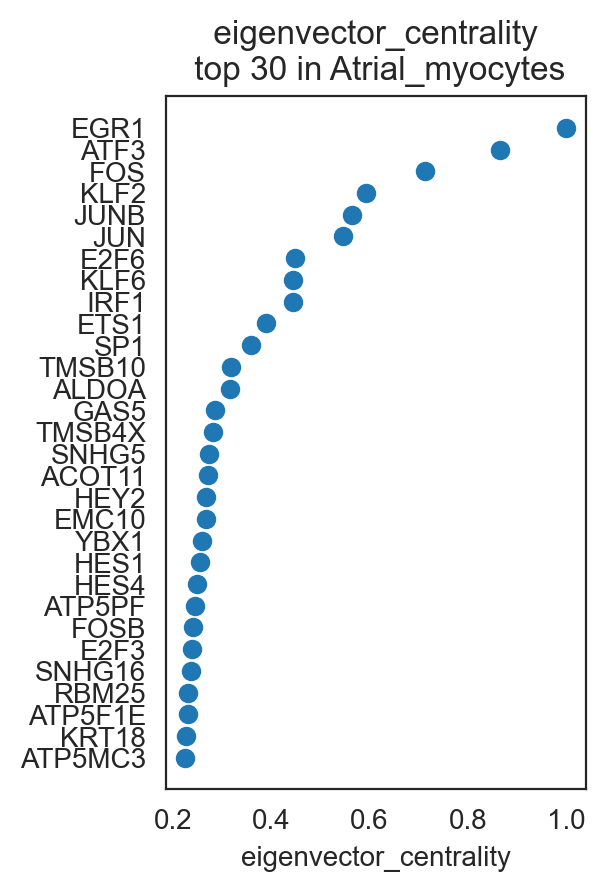

In [34]:
links.plot_scores_as_rank(cluster="Atrial_myocytes", n_gene=30, save=f"{save_folder}/ranked_score")

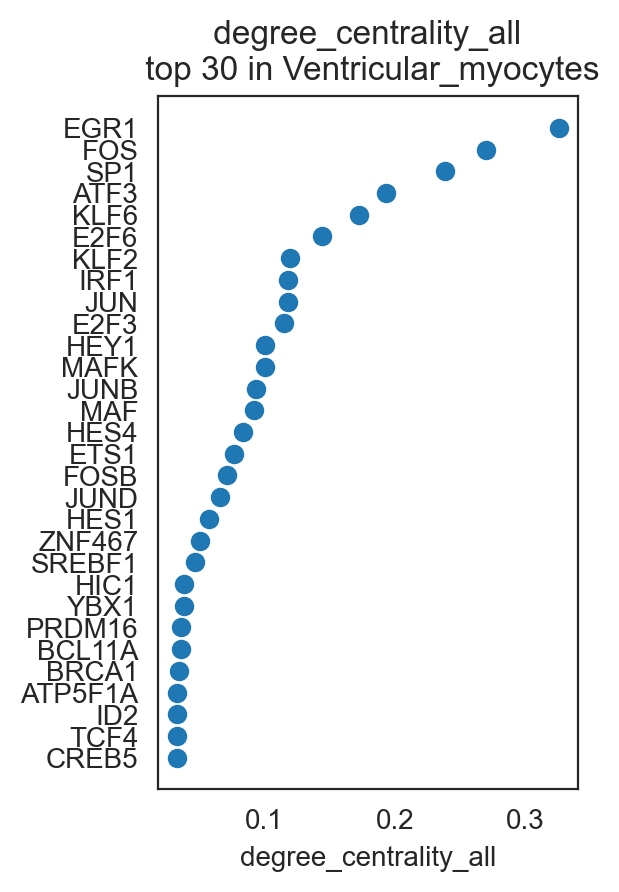

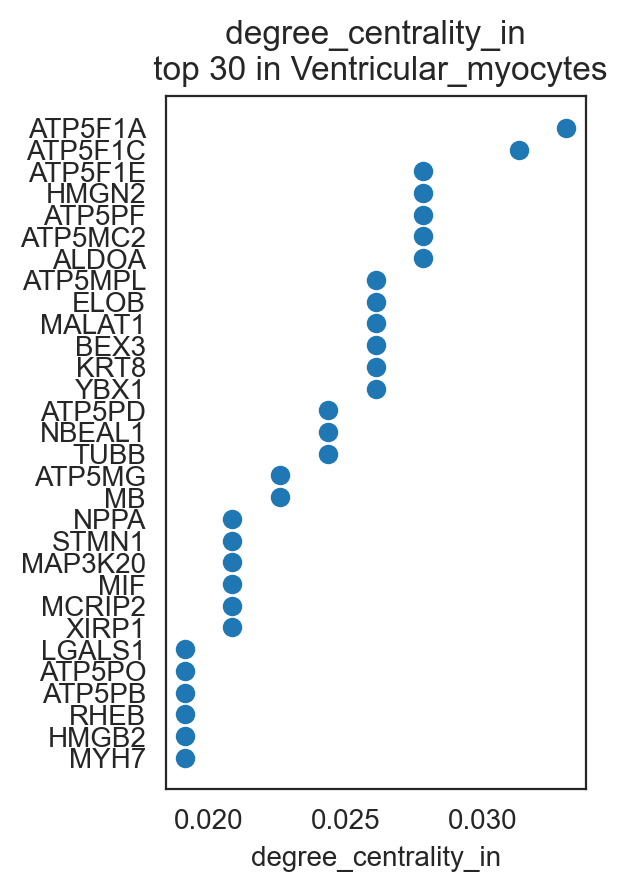

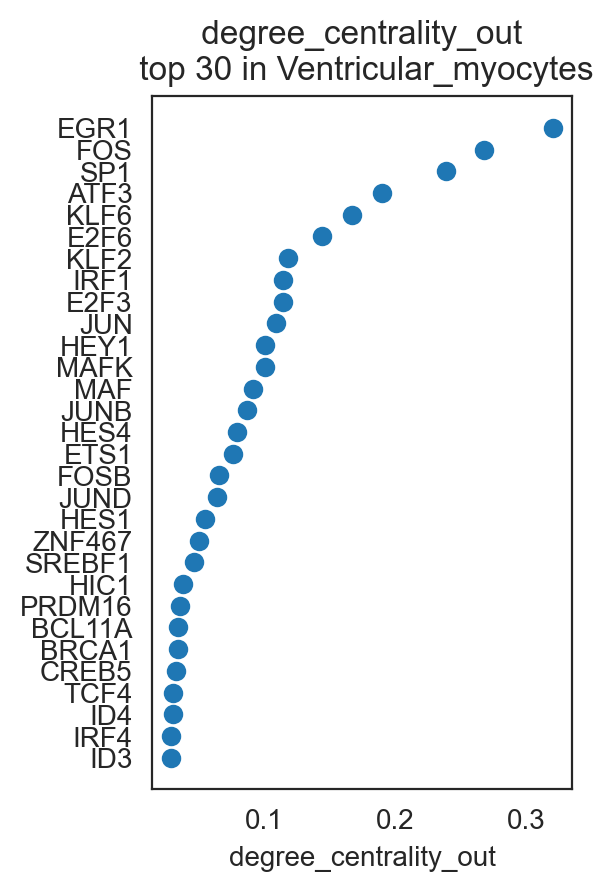

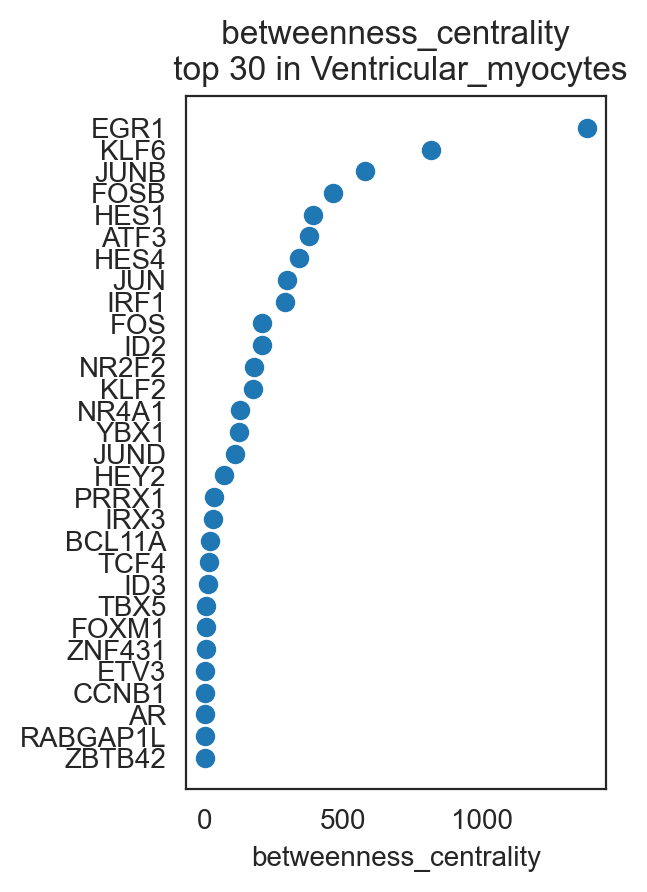

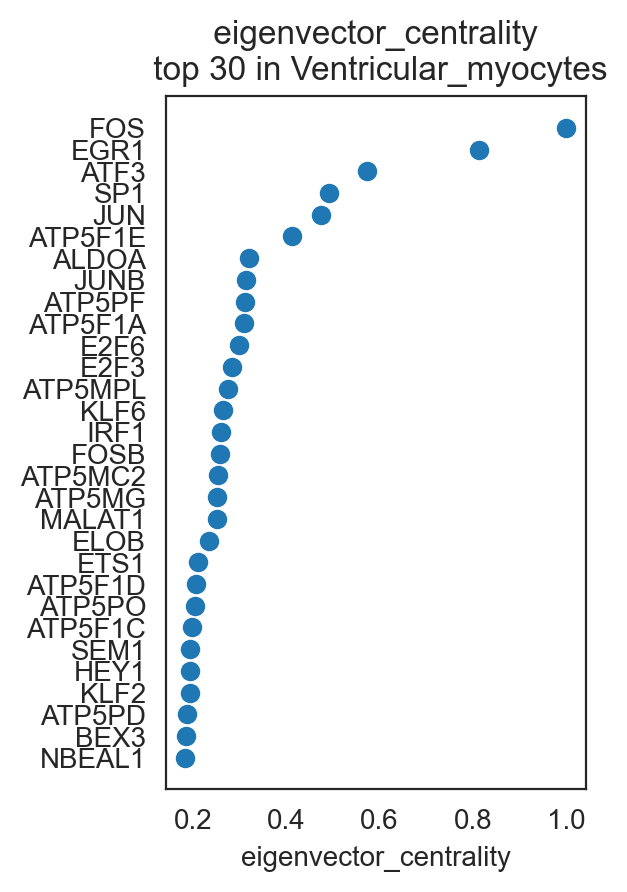

In [35]:
links.plot_scores_as_rank(cluster="Ventricular_myocytes", n_gene=30, save=f"{save_folder}/ranked_score")

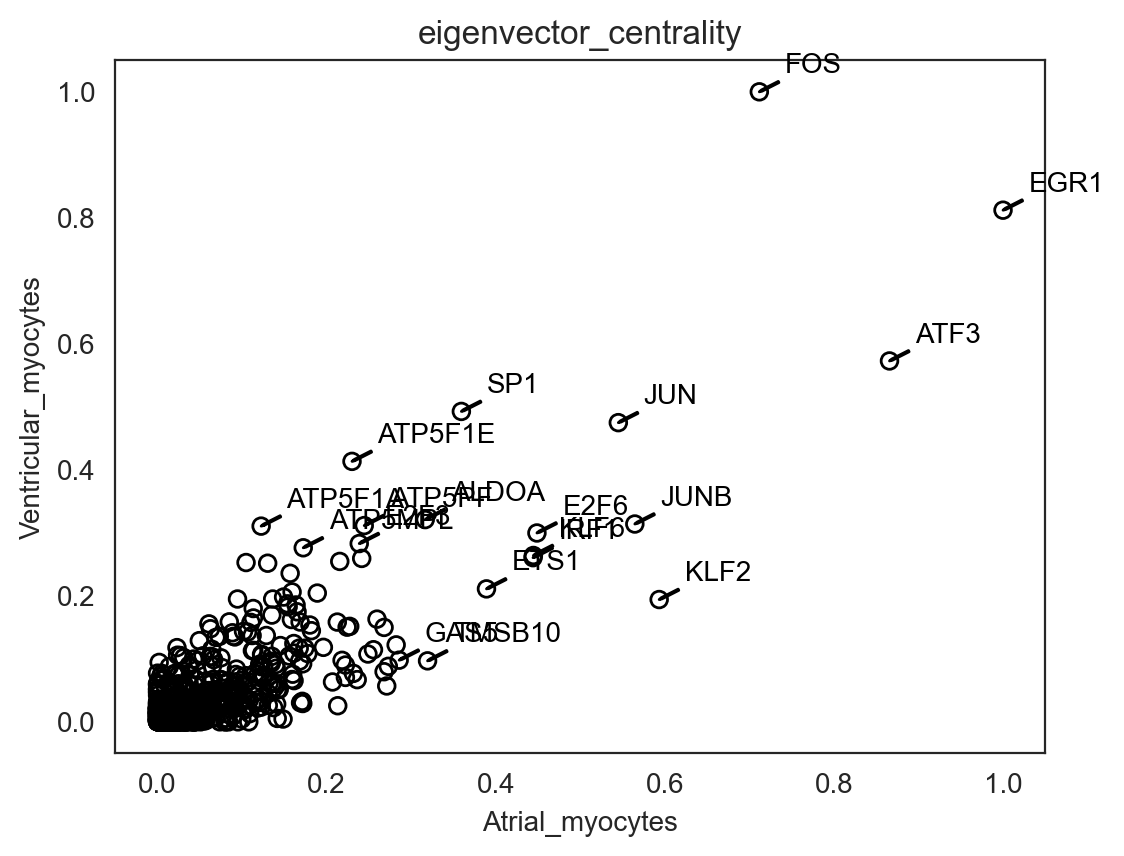

In [36]:
# Compare GRN score between two clusters
links.plot_score_comparison_2D(value="eigenvector_centrality", cluster1="Atrial_myocytes", cluster2="Ventricular_myocytes",percentile=98,save=f"{save_folder}/score_comparison")

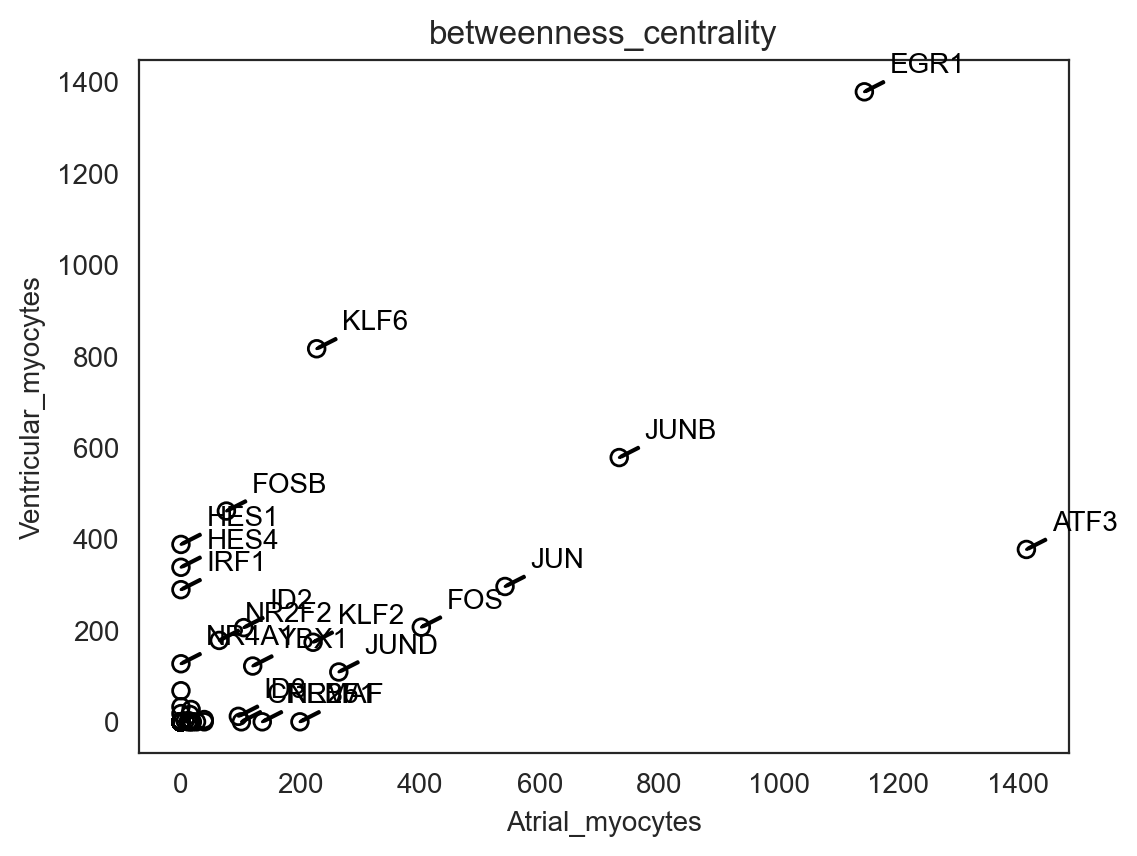

In [37]:
# Compare GRN score between two clusters
links.plot_score_comparison_2D(value="betweenness_centrality",cluster1="Atrial_myocytes", cluster2="Ventricular_myocytes",percentile=98,save=f"{save_folder}/score_comparison")

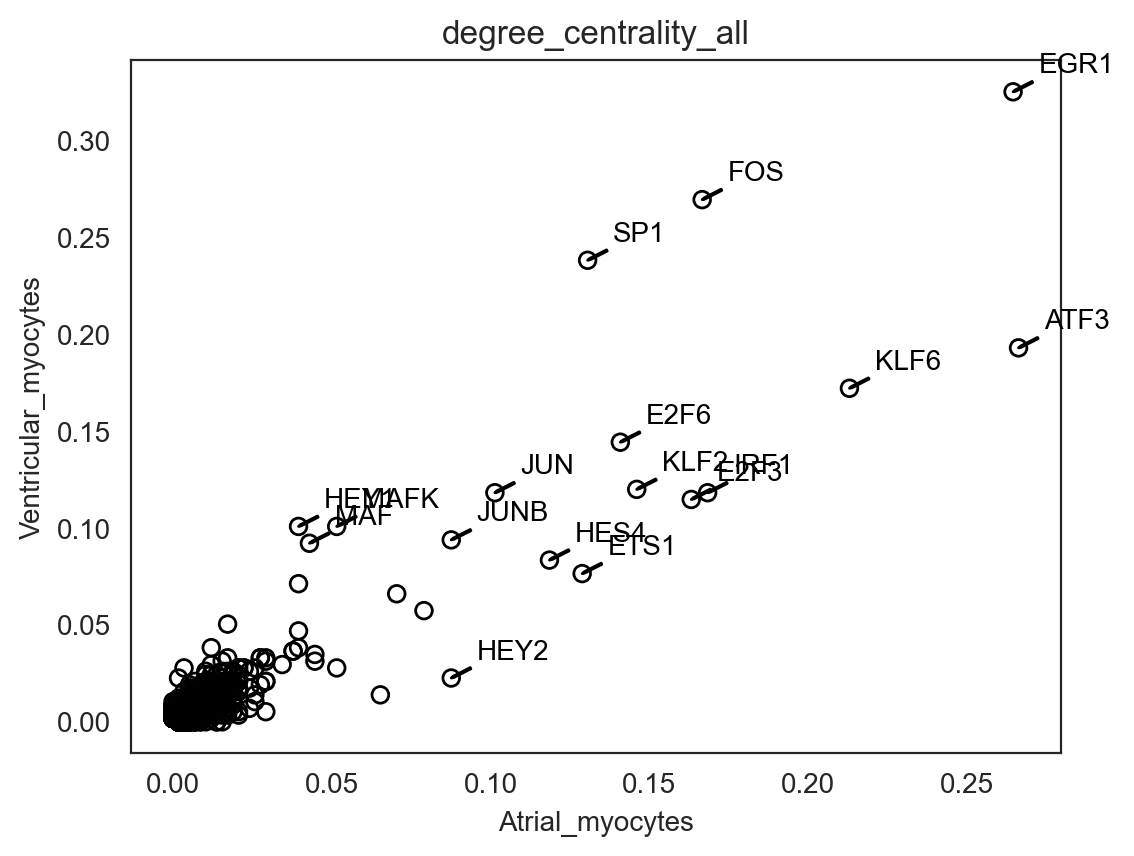

In [38]:
# Compare GRN score between two clusters
links.plot_score_comparison_2D(value="degree_centrality_all",cluster1="Atrial_myocytes", cluster2="Ventricular_myocytes",percentile=98, save=f"{save_folder}/score_comparison")

In [39]:
cluster_name = "Atrial_myocytes"
filtered_links_df = links.filtered_links[cluster_name]
filtered_links_df.head()

,source,target,coef_mean,coef_abs,p,-logp
39213,JUNB,TMSB4X,0.364673,0.364673,2.733276e-16,15.563317
39216,JUN,TMSB4X,-0.309733,0.309733,1.043333e-13,12.981577
13885,EGR1,FOS,0.298320,0.298320,6.715542e-23,22.172919
1208,JUN,ALDOA,-0.292439,0.292439,3.278450e-10,9.484331
2636,ATF3,ATP5F1B,0.283943,0.283943,1.684626e-09,8.773496


In [40]:
filtered_links_df[filtered_links_df.source == "NR2F2"]

,source,target,coef_mean,coef_abs,p,-logp
8535,NR2F2,COX6A2,-0.159709,0.159709,1.837267e-12,11.735828
25063,NR2F2,NES,0.094069,0.094069,6.704016e-11,10.173665
9160,NR2F2,CXCL12,0.073980,0.073980,1.975065e-13,12.704419
41317,NR2F2,VEGFA,0.049538,0.049538,4.967597e-12,11.303854
34540,NR2F2,SLC30A3,0.042177,0.042177,1.264554e-13,12.898063
41856,NR2F2,XIRP1,-0.041567,0.041567,4.990607e-07,6.301847


# 8. Network analysis; network score distribution

In [41]:
plt.rcParams["figure.figsize"] = [6, 4.5]

degree_centrality_all


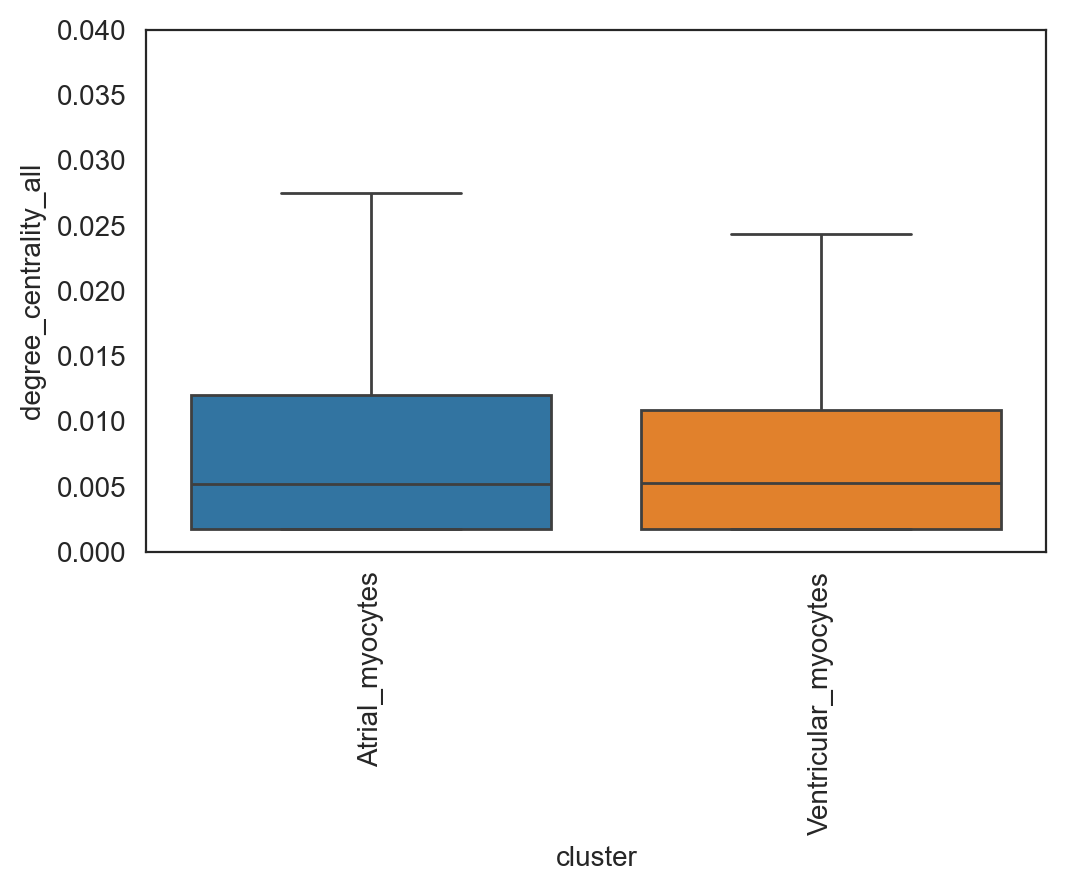

In [42]:
# Plot degree_centrality
plt.subplots_adjust(left=0.15, bottom=0.3)
plt.ylim([0,0.040])
links.plot_score_discributions(values=["degree_centrality_all"],method="boxplot",save=f"{save_folder}")

eigenvector_centrality


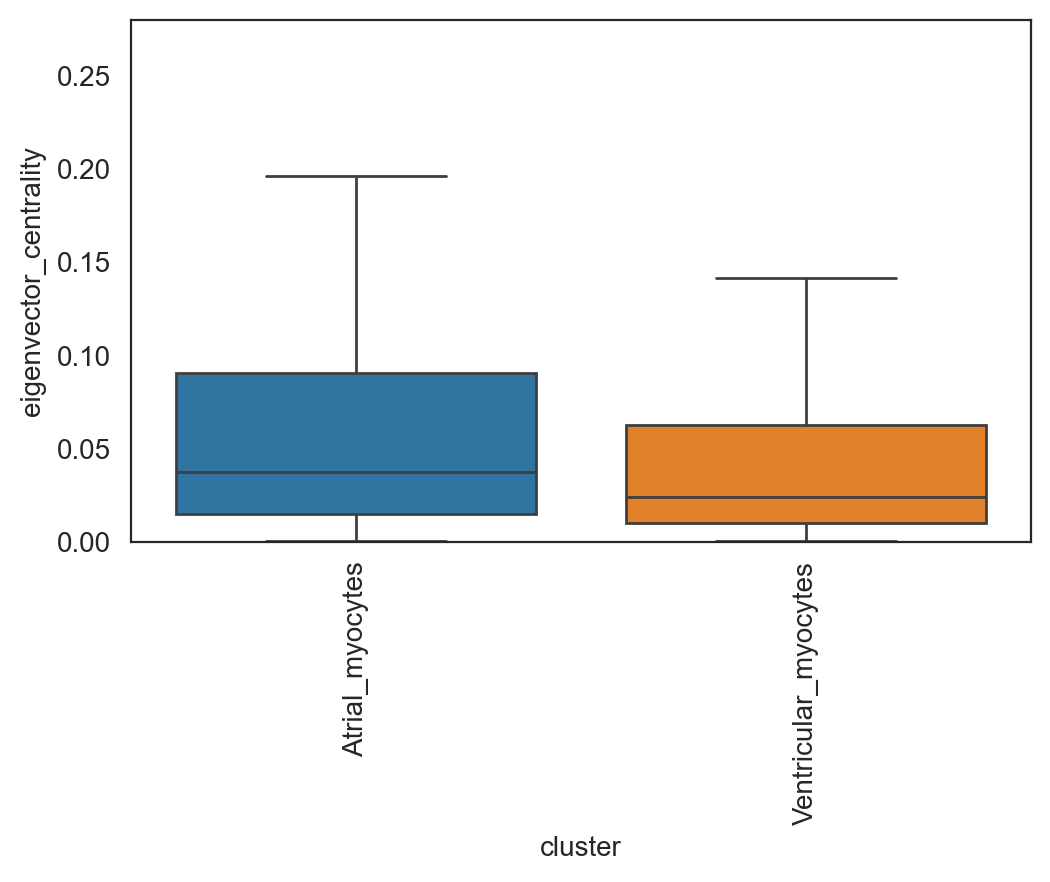

In [43]:
# Plot eigenvector_centrality
plt.subplots_adjust(left=0.15, bottom=0.3)
plt.ylim([0, 0.28])
links.plot_score_discributions(values=["eigenvector_centrality"],method="boxplot",save=f"{save_folder}")

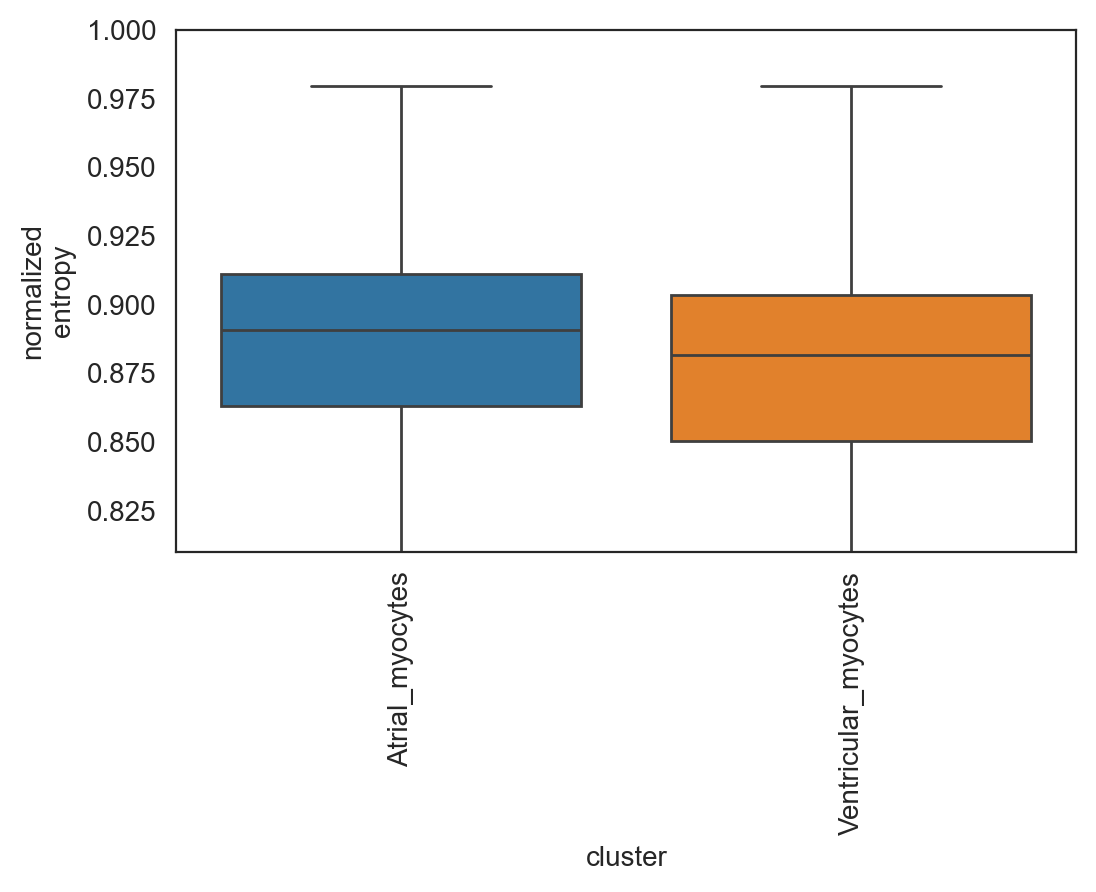

In [44]:
plt.subplots_adjust(left=0.15, bottom=0.3)
links.plot_network_entropy_distributions(save=f"{save_folder}")